<a href="https://colab.research.google.com/github/nafi-rahman/Comparative-Study-of-various-techniques-using-Deep-Learning-for-Brain-Tumor-Detection/blob/main/BrainTumor(Resnet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
from imgaug import augmenters as iaa
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.applications import resnet
from tensorflow.keras.applications import VGG16, ResNet50, ResNet101, InceptionResNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
from keras import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

img_rows, img_cols = 224, 224

isolated_train_path = "/content/drive/MyDrive/Database/BrainTumor(10K_new)/Training"
isolated_test_path = "/content/drive/MyDrive/Database/BrainTumor(10K_new)/Testing"

for root, dirnames, filenames in os.walk(isolated_train_path):
    for filename in filenames:
        file_path = os.path.join(root, filename)
        img = Image.open(file_path)
        grey = img.resize((img_rows, img_cols))
        grey.save(file_path)

train_data_dir = isolated_train_path
validation_data_dir = isolated_test_path

img_width, img_height, channel = img_rows, img_cols, 3
batch_size = 20

# Data augmentation settings
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,  # Rotate images randomly up to 20 degrees
    width_shift_range=0.2,  # Shift the width of the image randomly
    height_shift_range=0.2,  # Shift the height of the image randomly
    shear_range=0.2,  # Apply shear transformation randomly
    zoom_range=0.2,  # Zoom in/out randomly
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest'  # Fill newly created pixels after rotation or shift
)

validation_datagen = ImageDataGenerator(rescale=1./244)  # Only rescale for validation data

# Automatically retrieve images and their classes for training and validation
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical'
)

IMG_SHAPE = img_cols, img_rows, 3
classes = 4

num_epoch = 30
num_train_samples = train_generator.samples
num_validation_samples = validation_generator.samples

print('num_train_samples:', num_train_samples)
print('num_validation_samples:', num_validation_samples)


Found 8000 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.
num_train_samples: 8000
num_validation_samples: 2000


In [ ]:
class_names = list(train_generator.class_indices.keys())
print(class_names)

class_names = list(validation_generator.class_indices.keys())
print(class_names)

print(train_generator.class_indices)
print(validation_generator.class_indices)



['glioma', 'meningioma', 'notumor', 'pituitary']
['glioma', 'meningioma', 'notumor', 'pituitary']
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


Class 0: 2000 samples
Class 1: 2000 samples
Class 2: 2000 samples
Class 3: 2000 samples


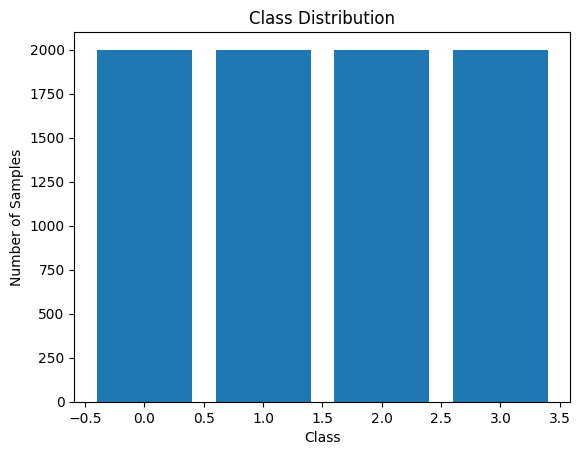

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get true labels
y_train_true = train_generator.classes

# Count samples per class
unique_classes, class_counts = np.unique(y_train_true, return_counts=True)
for class_label, count in zip(unique_classes, class_counts):
    print("Class {}: {} samples".format(class_label, count))


# Plot class distribution
plt.bar(unique_classes, class_counts)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.show()


In [ ]:
#resnet101v2

from tensorflow.keras import layers
from tensorflow.keras import models


def conv_block(inputs, filters, kernel_size, strides=(2, 2), padding="same"):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding=padding)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x


def identity_block(inputs, filters, kernel_size):
    x = layers.Conv2D(filters, kernel_size, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(filters, kernel_size, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([x, inputs])
    x = layers.Activation("relu")(x)
    return x


def resnet101v2(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    x = conv_block(inputs, filters=64, kernel_size=(7, 7), strides=(2, 2))
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(x)

    # Block 1
    x = identity_block(x, filters=64, kernel_size=(3, 3))
    x = identity_block(x, filters=64, kernel_size=(3, 3))
    x = identity_block(x, filters=64, kernel_size=(3, 3))

    # Block 2
    x = conv_block(x, filters=128, kernel_size=(3, 3), strides=(2, 2))
    x = identity_block(x, filters=128, kernel_size=(3, 3))
    x = identity_block(x, filters=128, kernel_size=(3, 3))
    x = identity_block(x, filters=128, kernel_size=(3, 3))

    # Block 3
    x = conv_block(x, filters=256, kernel_size=(3, 3), strides=(2, 2))
    x = identity_block(x, filters=256, kernel_size=(3, 3))
    x = identity_block(x, filters=256, kernel_size=(3, 3))
    x = identity_block(x, filters=256, kernel_size=(3, 3))
    x = identity_block(x, filters=256, kernel_size=(3, 3))
    x = identity_block(x, filters=256, kernel_size=(3, 3))

    # Block 4
    x = conv_block(x, filters=512, kernel_size=(3, 3), strides=(2, 2))
    x = identity_block(x, filters=512, kernel_size=(3, 3))
    x = identity_block(x, filters=512, kernel_size=(3, 3))
    x = layers.GlobalAveragePooling2D()(x)

    # Output layer
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    # Create model
    res101model = models.Model(inputs, outputs)
    return res101model
# Define model
input_shape = (224,224,3)
num_classes = 4
model = resnet101v2(input_shape, num_classes)

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
# Fit the model and store the history
history = model.fit(
    train_generator,
    steps_per_epoch=num_train_samples // batch_size,
    epochs=num_epoch,
    validation_data=validation_generator,
    validation_steps=num_validation_samples // batch_size
)




Epoch 1/30
400/400 [==============================] - 508s 1s/step - loss: 0.9947 - accuracy: 0.5914 - val_loss: 1.5800 - val_accuracy: 0.4205
Epoch 2/30
400/400 [==============================] - 153s 382ms/step - loss: 0.7617 - accuracy: 0.6925 - val_loss: 1.1557 - val_accuracy: 0.5670
Epoch 3/30
400/400 [==============================] - 149s 374ms/step - loss: 0.6580 - accuracy: 0.7402 - val_loss: 2.0626 - val_accuracy: 0.5170
Epoch 4/30
400/400 [==============================] - 150s 373ms/step - loss: 0.5831 - accuracy: 0.7761 - val_loss: 7.4587 - val_accuracy: 0.2555
Epoch 5/30
400/400 [==============================] - 145s 363ms/step - loss: 0.5161 - accuracy: 0.8061 - val_loss: 1.6557 - val_accuracy: 0.6045
Epoch 6/30
400/400 [==============================] - 147s 367ms/step - loss: 0.4578 - accuracy: 0.8309 - val_loss: 3.8715 - val_accuracy: 0.3325
Epoch 7/30
400/400 [==============================] - 146s 364ms/step - loss: 0.4026 - accuracy: 0.8508 - val_loss: 0.6323 - va

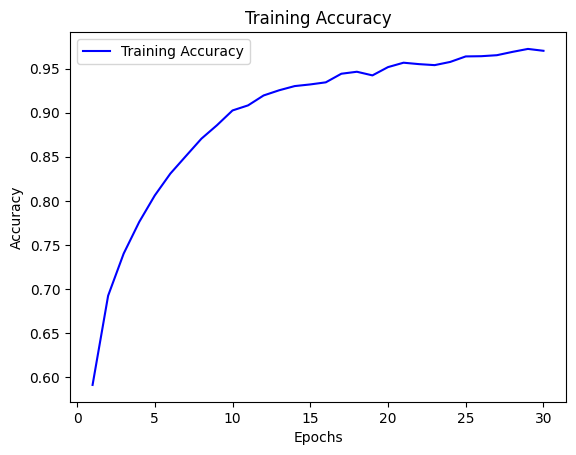

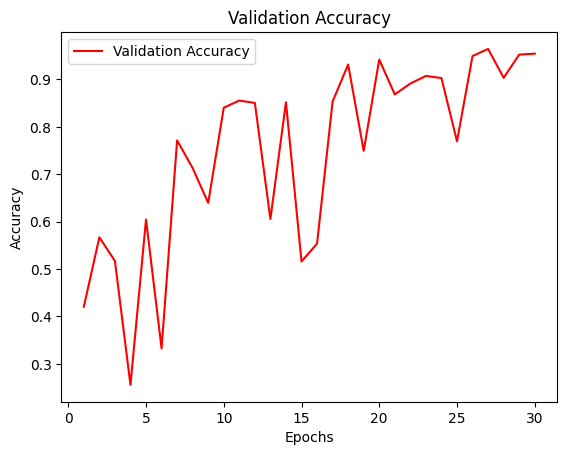

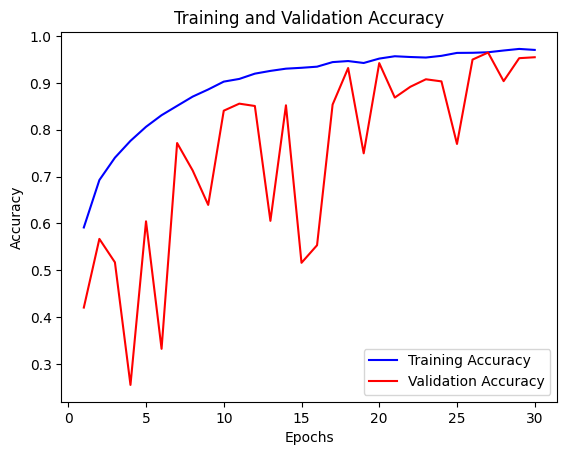

In [ ]:
# Plot training accuracy graph
epochs = range(1, num_epoch + 1)
train_acc = model.history.history['accuracy']  # Use 'accuracy' instead of 'acc'
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot validation accuracy graph
val_acc = model.history.history['val_accuracy']  # Use 'val_accuracy' instead of 'val_acc'
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation accuracy graph together
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.font_manager import FontProperties
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import itertools  # Import itertools module

# Generate predictions
y_train_pred = model.predict(train_generator)
y_val_pred = model.predict(validation_generator)

# Get true labels
y_train_true = train_generator.classes
y_val_true = validation_generator.classes

# Calculate accuracy
val_accuracy = accuracy_score(y_val_true, np.argmax(y_val_pred, axis=1))

# Calculate F1 score
val_f1_score = f1_score(y_val_true, np.argmax(y_val_pred, axis=1), average='weighted')

print("Validation Accuracy: {:.2f}%".format(val_accuracy * 100))
print("Validation F1 Score: {:.2f}".format(val_f1_score))



100/100 [==============================] - 7s 70ms/step
Validation Accuracy: 95.45%
Validation F1 Score: 0.95


Confusion matrix, without normalization
[[441  24  26   9]
 [  1 479  17   3]
 [  0   0 500   0]
 [  0   4   7 489]]


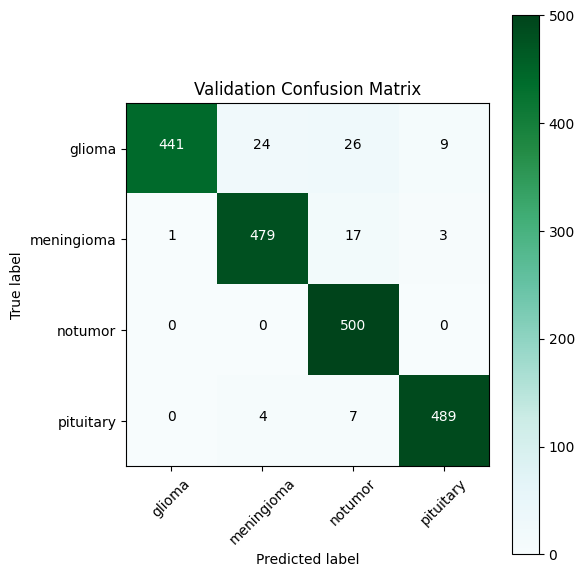

In [ ]:
# Confusion matrix
val_cm = confusion_matrix(y_val_true, np.argmax(y_val_pred, axis=1))

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.BuGn):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

class_names = train_generator.class_indices.keys()
plot_confusion_matrix(val_cm, classes=class_names, title='Validation Confusion Matrix')



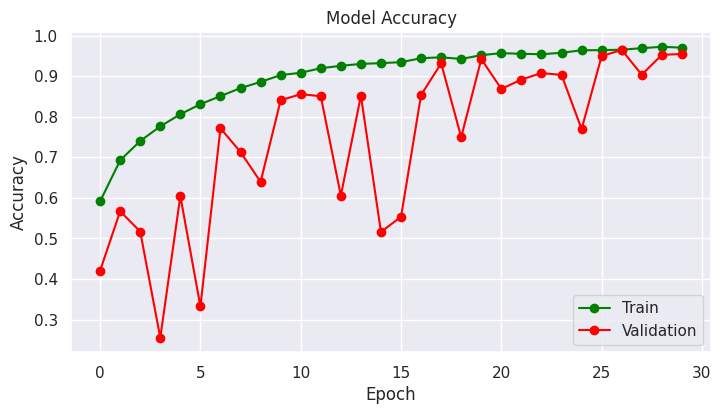

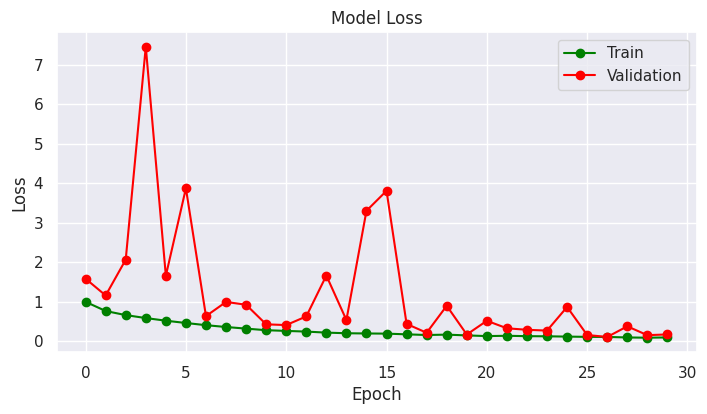

In [ ]:
import seaborn as sns
#  "Accuracy"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(history.history['accuracy'], 'o-', color="Green")
plt.plot(history.history['val_accuracy'] , 'o-', color="Red")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
# "Loss"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(history.history['loss'], 'o-', color="Green")
plt.plot(history.history['val_loss'], 'o-', color="Red")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.applications import ResNet101V2

def resnet101v2(input_shape, num_classes):
    base_model = ResNet101V2(include_top=False, weights='imagenet', input_shape=input_shape)

    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Add GlobalAveragePooling and output layer
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

# Define model
input_shape = (224, 224, 3)
num_classes = 4
model = resnet101v2(input_shape, num_classes)

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Print model summary
model.summary()

171317808/171317808 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                           

In [ ]:
# Fit the model and store the history
history = model.fit(
    train_generator,
    steps_per_epoch=num_train_samples // batch_size,
    epochs=num_epoch,
    validation_data=validation_generator,
    validation_steps=num_validation_samples // batch_size
)




Epoch 1/30
400/400 [==============================] - 656s 2s/step - loss: 0.5236 - accuracy: 0.8006 - val_loss: 0.4492 - val_accuracy: 0.8270
Epoch 2/30
400/400 [==============================] - 133s 332ms/step - loss: 0.3447 - accuracy: 0.8744 - val_loss: 0.4814 - val_accuracy: 0.8135
Epoch 3/30
400/400 [==============================] - 135s 337ms/step - loss: 0.3081 - accuracy: 0.8864 - val_loss: 0.3659 - val_accuracy: 0.8590
Epoch 4/30
400/400 [==============================] - 133s 332ms/step - loss: 0.2789 - accuracy: 0.8940 - val_loss: 0.3886 - val_accuracy: 0.8565
Epoch 5/30
400/400 [==============================] - 130s 325ms/step - loss: 0.2618 - accuracy: 0.9041 - val_loss: 0.3440 - val_accuracy: 0.8810
Epoch 6/30
400/400 [==============================] - 129s 323ms/step - loss: 0.2439 - accuracy: 0.9100 - val_loss: 0.3393 - val_accuracy: 0.8670
Epoch 7/30
400/400 [==============================] - 129s 324ms/step - loss: 0.2400 - accuracy: 0.9093 - val_loss: 0.2810 - va

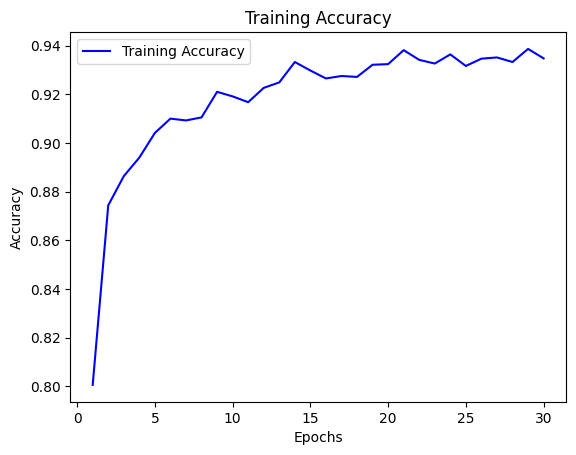

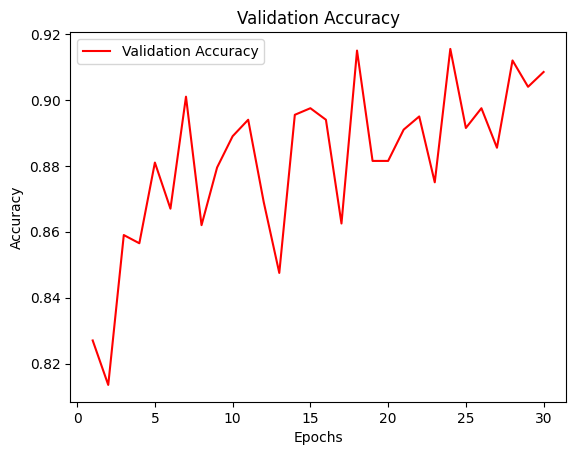

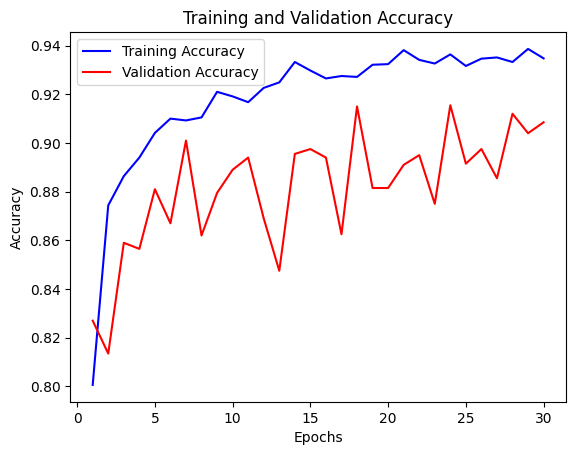

In [ ]:
# Plot training accuracy graph
epochs = range(1, num_epoch + 1)
train_acc = model.history.history['accuracy']  # Use 'accuracy' instead of 'acc'
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot validation accuracy graph
val_acc = model.history.history['val_accuracy']  # Use 'val_accuracy' instead of 'val_acc'
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation accuracy graph together
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.font_manager import FontProperties
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import itertools  # Import itertools module

# Generate predictions
y_train_pred = model.predict(train_generator)
y_val_pred = model.predict(validation_generator)

# Get true labels
y_train_true = train_generator.classes
y_val_true = validation_generator.classes

# Calculate accuracy
val_accuracy = accuracy_score(y_val_true, np.argmax(y_val_pred, axis=1))

# Calculate F1 score
val_f1_score = f1_score(y_val_true, np.argmax(y_val_pred, axis=1), average='weighted')

print("Validation Accuracy: {:.2f}%".format(val_accuracy * 100))
print("Validation F1 Score: {:.2f}".format(val_f1_score))



100/100 [==============================] - 7s 74ms/step
Validation Accuracy: 90.85%
Validation F1 Score: 0.91


Confusion matrix, without normalization
[[418  64   4  14]
 [ 13 410  20  57]
 [  1   2 496   1]
 [  0   7   0 493]]


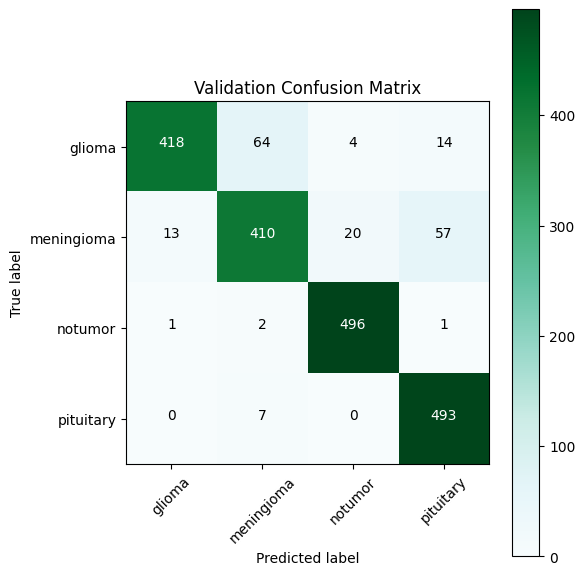

In [ ]:
# Confusion matrix
val_cm = confusion_matrix(y_val_true, np.argmax(y_val_pred, axis=1))

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.BuGn):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

class_names = train_generator.class_indices.keys()
plot_confusion_matrix(val_cm, classes=class_names, title='Validation Confusion Matrix')



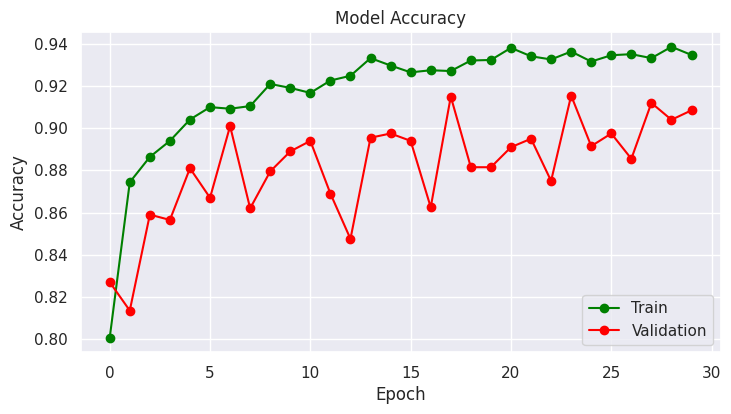

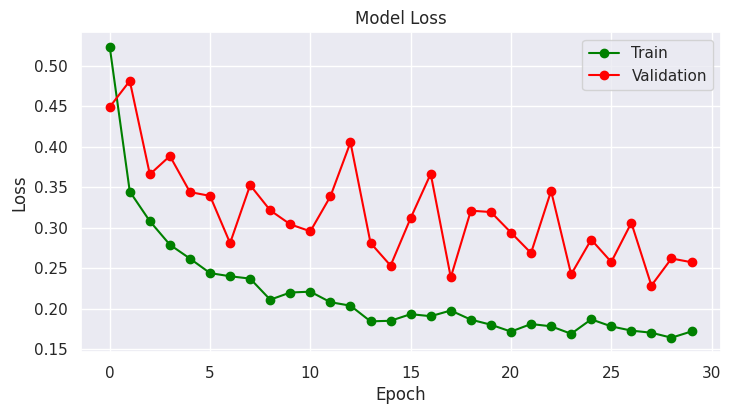

In [ ]:
import seaborn as sns
#  "Accuracy"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(history.history['accuracy'], 'o-', color="Green")
plt.plot(history.history['val_accuracy'] , 'o-', color="Red")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
# "Loss"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(history.history['loss'], 'o-', color="Green")
plt.plot(history.history['val_loss'], 'o-', color="Red")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])